In [2]:
import gmsh
import firedrake as fd
import os
import matplotlib.pylab as plt
import numpy as np

# Heat conduction in soil

Finite element analysis in Python using [Firedrake](https://www.firedrakeproject.org/) and [Gmesh](http://gmsh.info/)'s python [API](http://gmsh.info/doc/texinfo/gmsh.html#Gmsh-API).

## Gmesh: Geometry & mesh

In [19]:
gmsh.initialize()
gmsh.model.add("soil")

In [27]:
# Parameters
isolation_depth = .6  # m
isolation_thickness = .06  # m
house_half_size = 4  # m
domain_size = 14  # m

large_mesh = .5
element_size_min = .1  # m

In [21]:
# Points
# doc: addPoint(x, y, z, meshSize=0.0, tag=-1)
gmsh.model.geo.addPoint(-domain_size, 0, 0, tag=0)
gmsh.model.geo.addPoint(0, 0, 0, tag=1)
gmsh.model.geo.addPoint(0, -isolation_depth, 0, tag=2)
gmsh.model.geo.addPoint(isolation_thickness, -isolation_depth, 0, tag=3)
gmsh.model.geo.addPoint(isolation_thickness, 0, 0, tag=4)
gmsh.model.geo.addPoint(house_half_size, 0, 0, tag=5)
gmsh.model.geo.addPoint(house_half_size, -1.5*domain_size, 0, tag=6)
gmsh.model.geo.addPoint(-domain_size, -1.5*domain_size, 0, tag=7)
nbr_points = 8

In [22]:
# Lines
# doc: addLine(startTag, endTag, tag=-1)
for k in range(nbr_points):
    gmsh.model.geo.addLine(k, (k+1) % nbr_points, tag=k)

In [23]:
# Surface
polyline = gmsh.model.geo.addCurveLoop(list(range(nbr_points)))
gmsh.model.geo.addPlaneSurface([polyline], 1);

In [24]:
# Physical groups
gmsh.model.addPhysicalGroup(1, [0], tag=0)  # soil exterior
gmsh.model.addPhysicalGroup(1, [1, 2, 3], tag=1)  # insulation
gmsh.model.addPhysicalGroup(1, [4], tag=2)  # interior
gmsh.model.addPhysicalGroup(1, [5], tag=3)  # symmetry
gmsh.model.addPhysicalGroup(1, [6, 7], tag=4)  # infinite soil

gmsh.model.addPhysicalGroup(2, [1], tag=1); # soil surface

In [25]:
# help(gmsh.model.geo.mesh.setTransfiniteCurve)

In [28]:
# Somme d'une suite geométrique :
L = 1.5*domain_size
q = 1.2
a = element_size_min
np.log(1 - L/a*(1-q))/np.log(q) - 1

19.629486616024092

In [29]:
# have to be set in order !?
#gmsh.model.geo.mesh.setTransfiniteCurve(5, 20, meshType="Progression", coef=1.3)  # symmetry

gmsh.model.geo.mesh.setTransfiniteCurve(0, 18,
                                        meshType="Progression", coef=1/1.2)  # exterior

gmsh.model.geo.mesh.setTransfiniteCurve(1, int(isolation_depth//elt_size_min+1),
                                        meshType="Progression", coef=1)  # insulation exterior
gmsh.model.geo.mesh.setTransfiniteCurve(3, int(isolation_depth//elt_size_min+1),
                                        meshType="Progression", coef=1)  # insulation interior

gmsh.model.geo.mesh.setTransfiniteCurve(4, int(house_half_size//elt_size_min+1),
                                        meshType="Progression", coef=1.)  # interior

gmsh.model.geo.mesh.setTransfiniteCurve(5, 20,
                                        meshType="Progression", coef=1.2)  # interior

In [33]:
# Compute the mesh
gmsh.model.geo.synchronize()
#gmsh.model.mesh.generate(1)
gmsh.model.mesh.generate(2)

# Save
filename = 'soil.msh'
gmsh.write(filename + '2')
os.rename(filename + '2', filename)

# the format have to be 'msh2' for Firedrake

## Physics

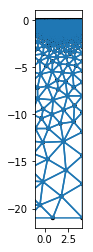

In [32]:
# load mesh
mesh = fd.Mesh(filename)
mesh.init()

# plot
ax = plt.subplot()
fd.plot(mesh, axes=ax) #, num_sample_points=1)
ax.set_xlim((-1, house_half_size));
#ax.set_ylim((-1, 0))
ax.set_aspect('equal')

In [34]:
# facet markers:
print(mesh.exterior_facets.unique_markers)

[0 1 2 3 4]


In [35]:
#mesh = fd.UnitSquareMesh(10, 10)

V = fd.FunctionSpace(mesh, "CG", 2)

u = fd.TrialFunction(V)
v = fd.TestFunction(V)

f = fd.Constant(0.)  # Source

L = f * v * fd.dx
# L += v * fd.Constant(20) * fd.ds(2)  # for convective boundary condition

In [36]:
k_soil = fd.Constant(1.28)  # Soil, W/m/K

a = k_soil * fd.dot(fd.grad(v), fd.grad(u)) * fd.dx
# a += v * u * fd.ds(2)  # for convective boundary condition

In [37]:
bc_int = fd.DirichletBC(V, 20, 2)
bc_ext = fd.DirichletBC(V, 0, 0)
all_bcs = [bc_int, bc_ext]

In [38]:
# Solve
u = fd.Function(V)
fd.solve(a == L, u, bcs=all_bcs) #, solver_parameters={'ksp_type': 'cg'})

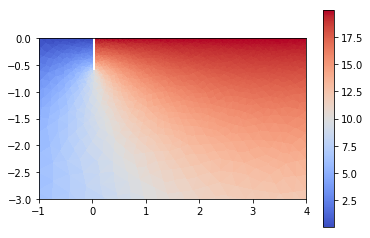

In [39]:
# plot
ax = plt.subplot()
fd.plot(u, axes=ax, num_sample_points=4, contour=False)
ax.set_xlim((-1, house_half_size));
ax.set_ylim((-3, 0))
ax.set_aspect('equal')

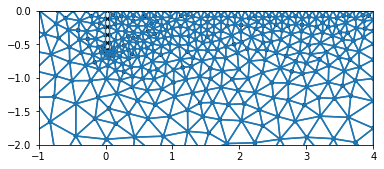

In [40]:
# plot
ax = plt.subplot()
fd.plot(mesh, axes=ax) #, num_sample_points=1)
ax.set_xlim((-1, house_half_size));
ax.set_ylim((-2, 0))
ax.set_aspect('equal')

In [41]:
# Flux sortant de `domain`
n = fd.FacetNormal(mesh)
flux_1 = fd.assemble( k_soil*fd.dot(fd.grad(u), n)*fd.ds(2))
flux_1

25.260445160237385

In [42]:
print( fd.assemble( fd.Constant(1., domain=mesh)*fd.ds(2) ) )
print(house_half_size - isolation_thickness)

3.94
3.94
